In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import uproot
import logging

import acts

from itertools import cycle

import awkward as ak

from gnn4itk_tools.detector_plotter import DetectorPlotter

In [119]:
class PrototrackPlotter(DetectorPlotter):
    def __init__(self):
        super().__init__("~/exatrkx/data/2K_geant4_pixel_geodigi/detectors.csv", r_max=200, abs_z_max=1500)
    
    def plot_prototrack(self, prototrack : pd.DataFrame, random_factor=0.1):
        colors = [ c for i, c in zip(range(len(prototrack)), cycle(matplotlib.colors.TABLEAU_COLORS)) ]
    
        prototrack = prototrack.copy()
        prototrack["r"] = np.hypot(prototrack.x, prototrack.y)

        pids, counts = np.unique(prototrack.particle_id, return_counts=True)
        pur = max(counts)/len(prototrack)
        
        fig, ax = self.get_fig_ax(figsize=(13,3))
        fig.suptitle("Prototrack with ID {} and lenght {}, purity: {:.1%}".format(str(prototrack.trackId.to_list()[0]), len(prototrack), pur))
    
        # move around a bit so we see overlaps
        f = random_factor
        def randomify(x):
            d = max(x) - min(x)
            r = np.random.uniform(-f*d,f*d,len(x))
            return x + r
    
        for k in ["x","y","z","r"]:
            prototrack[k] = randomify(prototrack[k])
        
        ax[0].scatter(prototrack.z, prototrack.r, color=colors, marker="x")
        ax[1].scatter(prototrack.x, prototrack.y, color=colors, marker="x")
    
        for c, (_, sp) in zip(colors, prototrack.iterrows()):
            ax[0].text(sp.z, sp.r+5, str(int(sp.measurementId)), c=c)
            ax[1].text(sp.x, sp.y+5, str(int(sp.measurementId)), c=c)
    
        ax[0].set_xlabel("z")
        ax[0].set_ylabel("r")
        ax[1].set_xlabel("x")
        ax[1].set_ylabel("y")
    
        fig.tight_layout()
        return fig, ax

In [120]:
plotter = PrototrackPlotter()

In [45]:
match_df = pd.read_csv("../output/gnn_ckf_no_threshold/performance_gnn_plus_ckf.csv", dtype={"particle_id": np.uint64})
match_df = match_df[ match_df.event == 0 ].copy()

In [46]:
particles = ak.to_dataframe(uproot.open("../10events/particles_initial.root:particles").arrays(), how="inner").reset_index(drop=True)
particles = particles[ particles.event_id == 0 ].copy()
particles = particles[ particles.particle_id.isin(match_df.particle_id) ].copy()
particles.shape

(2817, 22)

In [47]:
particles["matched"] = particles.particle_id.map(dict(zip(match_df.particle_id, match_df.matched)))
assert not any(pd.isna(particles.matched))
particles.head(2)

,event_id,particle_id,particle_type,process,vx,vy,vz,vt,px,py,...,eta,phi,pt,p,vertex_primary,vertex_secondary,particle,generation,sub_particle,matched
0,0,4503599644147712,-211,0,-0.006878,0.006443,26.299278,0.0,-0.478892,0.325085,...,-0.953069,2.545218,0.578807,0.862196,1,0,1,0,0,1
1,0,4503599660924928,211,0,-0.006878,0.006443,26.299278,0.0,0.369345,-0.488633,...,-0.629404,-0.923547,0.612518,0.737901,1,0,2,0,0,1


In [48]:
hits = uproot.open("../10events/hits.root:hits").arrays(library="pd")
hits = hits[ (hits.event_id == 0) & (hits.tt < 25.0) ].copy()
hits["hit_id"] = np.arange(len(hits))
hits.head(2)

simhit_map = pd.read_csv("../output/gnn_ckf_no_threshold/digi/event000000000-measurement-simhit-map.csv")
measId_to_hitID = dict(zip(simhit_map.measurement_id, simhit_map.hit_id))
hitId_to_particleId = dict(zip(hits.hit_id, hits.particle_id))

def process_prototracks(tracks):
    tracks["hit_id"] = tracks["measurementId"].map(measId_to_hitID)
    tracks["tx"] = tracks.hit_id.map(dict(zip(hits.hit_id, hits.tx)))
    tracks["ty"] = tracks.hit_id.map(dict(zip(hits.hit_id, hits.ty)))
    tracks["tz"] = tracks.hit_id.map(dict(zip(hits.hit_id, hits.tz)))
    tracks["geometry_id"] = tracks.hit_id.map(dict(zip(hits.hit_id, hits.geometry_id)))
    tracks["particle_id"] = tracks.hit_id.map(hitId_to_particleId)
    return tracks

In [49]:
prototracks = pd.read_csv("../output/gnn_ckf_no_threshold/gnn_plus_ckf/event000000000-prototracks.csv")
prototracks = process_prototracks(prototracks)
prototracks.head(2)

,trackId,measurementId,x,y,z,hit_id,tx,ty,tz,geometry_id,particle_id
0,0,25709,-25.141415,19.724676,-444.374018,25716,-25.129629,19.739695,-444.373993,1224979236083771648,243194380582649856
1,0,13707,-42.105389,32.421329,-615.600000,13709,-42.116688,32.409573,-615.599976,1152922604118475521,243194380582649856


In [55]:
true_prototracks = pd.read_csv("../output/gnn_ckf_no_threshold/proof_of_concept/event000000000-prototracks.csv")
true_prototracks = process_prototracks(true_prototracks)
true_prototracks = [ t for _, t in true_prototracks.groupby("trackId") ]

In [56]:
particles_eta_slice = particles[ particles.eta.between(-0.1,0.1) & (particles.matched == 0) ].reset_index()
len(particles_eta_slice)

10

In [57]:
prototracks_slice = [
    t for _, t in prototracks[ 
        prototracks.trackId.isin(
            np.unique(prototracks[ prototracks.particle_id.isin(particles_eta_slice.particle_id) ].trackId)
        )
    ].groupby("trackId") 
]
len(prototracks_slice)

5

In [58]:
prototracks_slice[0]

,trackId,measurementId,x,y,z,hit_id,tx,ty,tz,geometry_id,particle_id
2896,433,16303,31.820887,3.035966,9.424999,16305,31.822895,3.019320,9.434012,1224979236083731456,616993149604069376
2897,433,16367,31.551535,5.269785,28.825001,16369,31.552271,5.263678,28.841990,1224979236083731456,162129589974335488
2898,433,17216,33.539423,5.562228,28.825001,17218,33.539764,5.561623,28.841364,1224979236083735040,162129589974335488
2899,433,29307,67.258240,7.702166,14.775000,29314,67.257774,7.706036,14.771411,1224979373522684928,616993149604069376
2900,433,29682,67.900921,10.173933,28.775001,29689,67.897591,10.184105,28.766853,1224979373522688512,162129589974335488
2901,433,29666,68.637745,7.923009,14.975000,29673,68.638947,7.919342,14.980769,1224979373522688512,616993149604069376
2902,433,39405,112.815867,15.956510,21.776032,39415,112.820549,15.937457,21.790907,1224979510961641984,616993149604069376
2903,433,39413,113.161705,14.548357,28.625000,39423,113.163147,14.542472,28.649282,1224979510961641984,162129589974335488
2904,433,47371,168.871289,17.451663,28.475000,47386,168.871429,17.451004,28.451773,1224979648400595456,162129589974335488
2905,433,48238,167.439910,29.181013,30.275001,48253,167.435623,29.195854,30.260666,1224979648400634880,616993149604069376


In [59]:
particles[ particles.particle_id.isin(prototracks_slice[0].particle_id) ]

,event_id,particle_id,particle_type,process,vx,vy,vz,vt,px,py,...,eta,phi,pt,p,vertex_primary,vertex_secondary,particle,generation,sub_particle,matched
794,0,162129589974335488,211,0,-0.004888,-0.03195,28.821949,0.0,0.537994,0.098306,...,0.000514,0.180734,0.546902,0.546902,36,0,202,0,0,0


(0.0, 200.0)

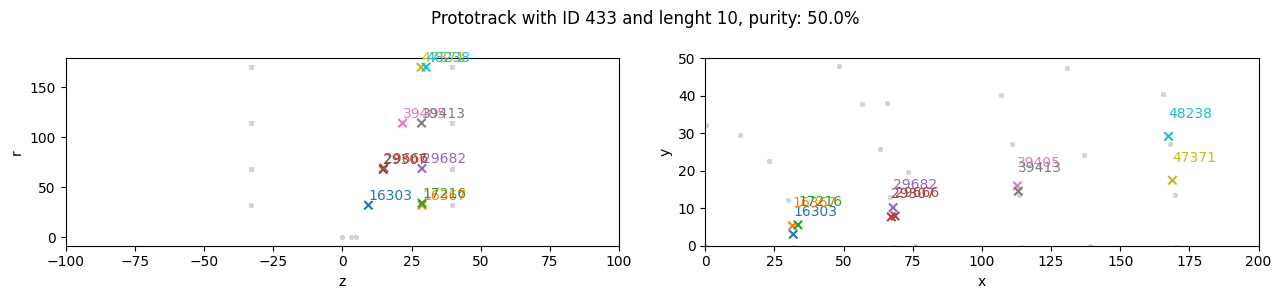

In [121]:
fig, ax = plotter.plot_prototrack(prototracks_slice[0], 0)
ax[0].set_xlim(-100, 100)
ax[1].set_ylim(0, 50)
ax[1].set_xlim(0, 200)

In [81]:
prototracks_slice[1]

,trackId,measurementId,x,y,z,hit_id,tx,ty,tz,geometry_id,particle_id
11800,1852,22173,31.664740,-5.423965,49.975000,22179,31.666588,-5.417358,49.983494,1224979236083756544,175640385685553152
11801,1852,16364,32.867834,-5.646676,49.685566,16366,32.867310,-5.642331,49.690948,1224979236083731456,175640385685553152
11802,1852,37290,66.942209,-12.447159,41.325001,37300,66.943108,-12.435399,41.333061,1224979373522774528,175640385685553152
11803,1852,46391,111.399722,-22.985124,30.342381,46406,111.400452,-22.979164,30.345371,1224979510961803264,175640385685553152
11804,1852,53596,165.485326,-38.735291,16.575001,53614,165.485138,-38.736832,16.569796,1224979648400853504,175640385685553152
11805,1852,53701,167.900447,-29.309077,18.175001,53719,167.900269,-29.313560,18.174398,1224979648400857088,680096324065951744


In [122]:
[ t for t in true_prototracks if np.unique(prototracks_slice[1].particle_id)[0] in t.particle_id ]

[]

In [123]:
particles_eta_slice[ particles_eta_slice.particle_id.isin(prototracks_slice[1].particle_id) ]

,index,event_id,particle_id,particle_type,process,vx,vy,vz,vt,px,...,eta,phi,pt,p,vertex_primary,vertex_secondary,particle,generation,sub_particle,matched
5,2631,0,680096324065951744,211,0,55.538036,-15.586205,9.060873,0.198284,0.990804,...,0.081271,-0.092341,0.995043,0.998331,151,48,225,0,0,0


(0.0, 200.0)

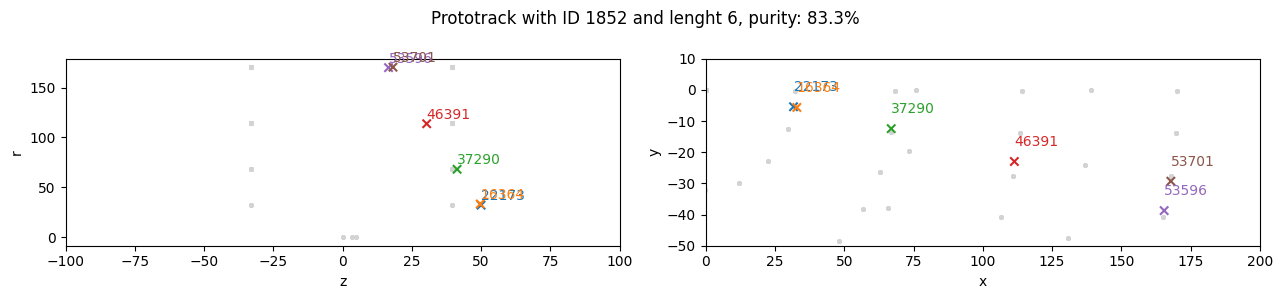

In [124]:
fig, ax = plotter.plot_prototrack(prototracks_slice[1], 0)
ax[0].set_xlim(-100, 100)
ax[1].set_ylim(-50, 10)
ax[1].set_xlim(0, 200)

(-30.0, 30.0)

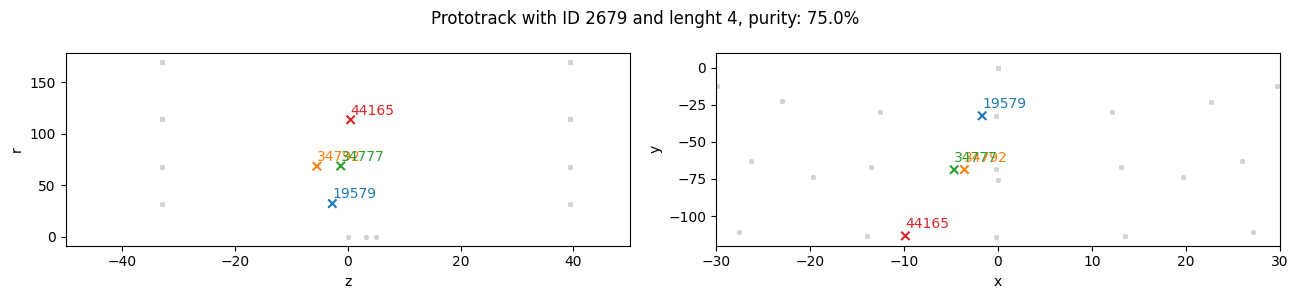

In [125]:
fig, ax = plotter.plot_prototrack(prototracks_slice[2], 0)
ax[0].set_xlim(-50, 50)
ax[1].set_ylim(-120, 10)
ax[1].set_xlim(-30, 30)

In [127]:
prototracks_slice[3]

,trackId,measurementId,x,y,z,hit_id,tx,ty,tz,geometry_id,particle_id
19780,3157,23770,15.608531,28.816462,16.075001,23777,15.608398,28.816500,16.058628,1224979236083763712,774729093613617152
19781,3157,37885,31.849339,59.752884,12.940330,37895,31.832842,59.761242,12.947840,1224979373522781696,774729093613617152
19782,3157,38177,32.538775,61.194159,12.812887,38187,32.534428,61.195374,12.802971,1224979373522785280,774729093613617152
19783,3157,47169,50.767822,101.981045,8.725000,47184,50.747929,101.988609,8.716556,1224979510961821184,774729093613617152
19784,3157,47178,51.048239,101.874431,7.674999,47193,51.059036,101.870323,7.675995,1224979510961821184,112589991154024448
19785,3157,47786,73.661544,153.519919,12.575001,47801,73.674698,153.515518,12.579124,1224979648400613376,112589991154024448


(0.0, 200.0)

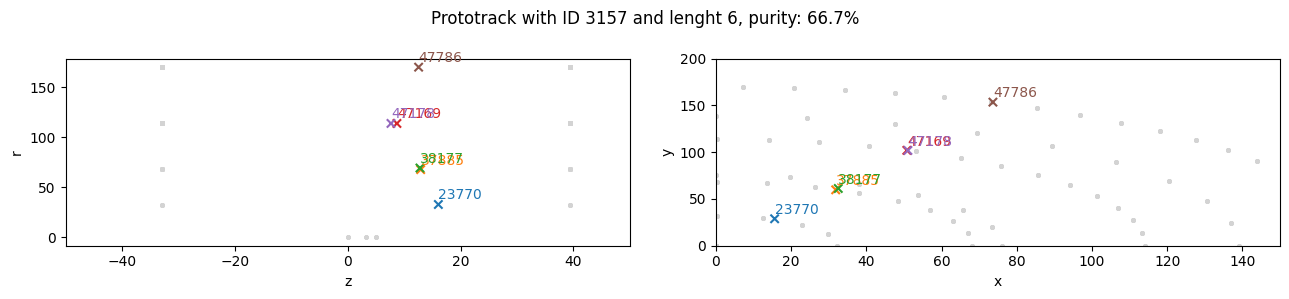

In [126]:
fig, ax = plotter.plot_prototrack(prototracks_slice[3], 0)
ax[0].set_xlim(-50, 50)
ax[1].set_xlim(0,150)
ax[1].set_ylim(0,200)

In [112]:
prototracks_slice[4]

,trackId,measurementId,x,y,z,hit_id,tx,ty,tz,geometry_id,particle_id
28190,4546,33480,-44.551183,-51.091157,7.224998,33489,-44.555767,-51.087559,7.204010,1224979373522731520,860187529079422976
28191,4546,43342,-75.960171,-85.304069,5.925003,43356,-75.954430,-85.308037,5.930745,1224979510961735168,860187529079422976
28192,4546,51044,-116.568039,-123.736358,24.275001,51061,-116.559586,-123.742722,24.284559,1224979648400749568,171136786091737088


(-50.0, 100.0)

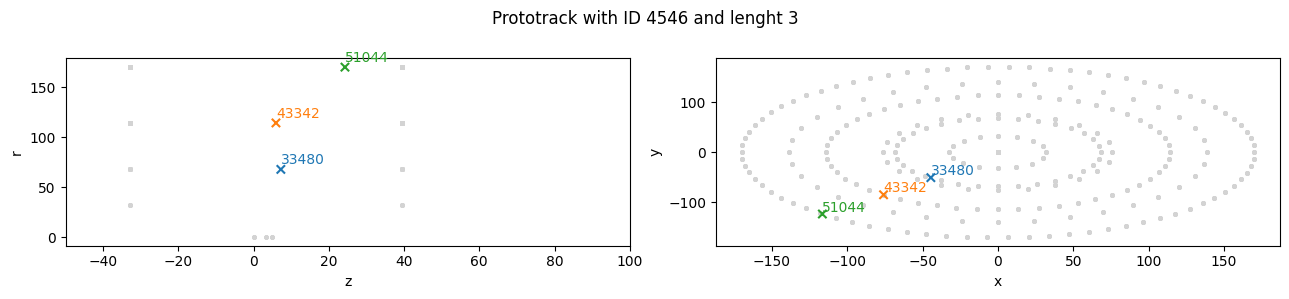

In [111]:
fig, ax = plotter.plot_prototrack(prototracks_slice[4], 0)
ax[0].set_xlim(-50, 100)
#ax[1].set_xlim(0,150)
#ax[1].set_ylim(0,200)